# Unet

In [64]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

## Modeling

In [65]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # conv 3x3, batch normalization, relu
        def CB(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    bias=bias
                )
            ]
            layers += [ nn.BatchNorm2d(num_features=out_channels) ]
            layers += [ nn.ReLU() ]

            conv_block = nn.Sequential(*layers)
            return conv_block
        
        # UNet Encoder
        self.enc1_1 = CB(in_channels=1, out_channels=64)
        self.enc1_2 = CB(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CB(in_channels=64, out_channels=128)
        self.enc2_2 = CB(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CB(in_channels=128, out_channels=256)
        self.enc3_2 = CB(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CB(in_channels=256, out_channels=512)
        self.enc4_2 = CB(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CB(in_channels=512, out_channels=1024)

        # UNet Decoder
        self.dec5_1 = CB(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        # in_channels = 512*2인 이유는 encoder에서 사용했던 feature map을 decoder에서도 사용할 수 있도록
        # forward에서 dec와 enc을 concat해주기 때문
        self.dec4_2 = CB(in_channels=512*2, out_channels=512)
        self.dec4_1 = CB(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CB(in_channels=256*2, out_channels=256)
        self.dec3_1 = CB(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CB(in_channels=128*2, out_channels=128)
        self.dec2_1 = CB(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CB(in_channels=64*2, out_channels=64)
        self.dec1_1 = CB(in_channels=64, out_channels=64)
        
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        # Encoder
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # Decoder
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        
        # UNet 구조 중 encoder에서 사용했던 feature map을 decoder에서 동일하게 사용하도록 구축
        # dim=[0:batch, 1:channel, 2:height, 3:width]
        
        cat4 = torch.cat((enc4_2, unpool4), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((enc3_2, unpool3), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((enc2_2, unpool2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((enc1_2, unpool1), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x


## Data

In [66]:
# 데이터 저장경로
data_dir = "data/unet"

name_label = "train-labels.tif"
name_input = "train-volume.tif"

img_label = Image.open(os.path.join(data_dir, name_label))
img_input = Image.open(os.path.join(data_dir, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print("nx", nx)
print("ny", ny)
print("frame", nframe)

nx 512
ny 512
frame 30


[ 2 10 20 12  9 13 29 19 17  4  5  6  7 11 18 25  8 24 16 23 15 22  1 27
 14 26 28  0 21  3]


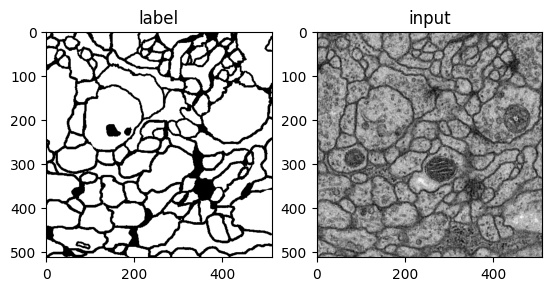

In [67]:
# 데이터는 총 30프레임으로 구성 train:val:test = 24:3:3
nframe_train = 24
nframe_val = 3
nframe_test = 3

# 데이터 나눠서 저장할 경로 설정
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# 경로 폴더 만들기
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# 데이터 랜덤 설정
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)
print(id_frame)

# 데이터 섞어서 train 저장
offset_nframe = 0
for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(train_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(train_dir, f"input_{i:03d}.npy"), input_)

# 데이터 섞어서 val 저장
offset_nframe += nframe_train
for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(val_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(val_dir, f"input_{i:03d}.npy"), input_)

# 데이터 섞어서 test 저장
offset_nframe += nframe_val
for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(test_dir, f"label_{i:03d}.npy"), label_)
    np.save(os.path.join(test_dir, f"input_{i:03d}.npy"), input_)
    
# 데이터 확인
plt.subplot(121)
plt.imshow(label_, cmap="gray")
plt.title("label")

plt.subplot(122)
plt.imshow(input_, cmap="gray")
plt.title("input")

plt.show()


## Dataset, DataLoader 구성

In [68]:
# dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # 데이터 파일 리스트 받기
        lst_data = os.listdir(self.data_dir)

        lst_label = [ f for f in lst_data if f.startswith("label") ]
        lst_input = [ f for f in lst_data if f.startswith("input") ]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self, index):
        labels = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # normalization
        labels = labels/255.0
        inputs = inputs/255.0
        
        # torch 는 반드시 3차원이어야하기 때문에 채널이 없는 경우 채널을 만들어주는 로직
        if labels.ndim == 2:
            labels = labels[:, :, np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:, :, np.newaxis]

        data = { "inputs": inputs, "labels": labels}

        if self.transform:
            data = self.transform(data)

        return data


### Data transpose

input shape (512, 512, 1)
label shape (512, 512, 1)


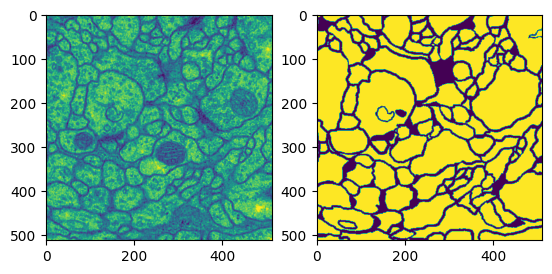

In [69]:
# transform 구현
class MyToTensor(object):
    def __call__(self, data):
        inputs, labels = data["inputs"], data["labels"]

        inputs = inputs.transpose((2, 0, 1)).astype(np.float32)
        labels = labels.transpose((2, 0, 1)).astype(np.float32)

        # inputs = torch.from_numpy(inputs)
        # labels = torch.from_numpy(labels)

        data = {
            "inputs": torch.from_numpy(inputs), 
            "labels": torch.from_numpy(labels)
        }
        return data
    
class MyNormalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        inputs, labels = data["inputs"], data["labels"]

        inputs = (inputs - self.mean) / self.std

        data = { "inputs": inputs, "labels": labels}
        return data

class RandomFlip(object):
    def __call__(self, data):
        inputs, labels = data["inputs"], data["labels"]

        # 50% 좌우 반전
        if np.random.rand() > 0.5:
            inputs = np.fliplr(inputs)
            labels = np.fliplr(labels)

        # 50% 상하 반전
        if np.random.rand() > 0.5:
            inputs = np.flipud(inputs)
            labels = np.flipud(labels)
        
        data = { "inputs": inputs, "labels": labels}
        return data

# data loader가 잘 되었는지 확인
train_data = MyDataset(data_dir=os.path.join(data_dir, "train"))
data = train_data[0]
inputs = data["inputs"]
labels = data["labels"]

print("input shape", inputs.shape)
print("label shape", labels.shape)

# 시각화
plt.subplot(121)
plt.imshow(inputs)
plt.subplot(122)
plt.imshow(labels)

## 모델 학습

In [70]:
# 하이퍼파라미터
lr = 1e-3
batch_size = 4
n_epoch = 100

# train model 저장경로
ckpt_dir = "./checkpoint"

# memory
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print("device", device)


device mps


In [71]:
# transforms
train_transform = transforms.Compose([
    MyNormalization(),
    RandomFlip(),
    MyToTensor()
])

test_transform = transforms.Compose([
    MyNormalization(),
    MyToTensor()
])

# Dataset
train_set = MyDataset(data_dir=os.path.join(data_dir, "train"), transform=train_transform)
val_set = MyDataset(data_dir=os.path.join(data_dir, "val"), transform=train_transform)
test_set = MyDataset(data_dir=os.path.join(data_dir, "test"), transform=test_transform)

# DataLoader
train_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [72]:
# loss 추이 확인을 위한 변수 설정
num_data_train = len(train_set)
num_data_val = len(val_set)
num_data_test = len(test_set)

num_batch_train = np.ceil(num_data_train/batch_size)
num_batch_val = np.ceil(num_data_val/batch_size)
num_batch_test = np.ceil(num_data_test/batch_size)

In [73]:
# 모델
model = UNet().to(device)

fn_loss = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [74]:
# 그 외 함수
fn_tonumpy = lambda x: x.to("cpu").detach().numpy().transpose(0, 2, 3, 1)
fb_denorm = lambda x, mean, std: (x*std)+mean
fn_class = lambda x: 1.0*(x>0.5)

# 모델 저장
def save_model(ckpt_dir, model, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    
    torch.save(
        {
            "model": model.state_dict(),
            "optim": optim.state_dict(),
        },
        f"./{ckpt_dir}/model_{epoch:02d}.pth"
    )

In [75]:
# 모델 학습
for epoch in range(1, n_epoch+1):
    model.train()
    batch_loss = []
    epoch_loss = []

    for batch, data in enumerate(train_dl, 1):
        labels = data["labels"].to(device)
        inputs = data["inputs"].to(device)

        output = model(inputs)
        
        loss = fn_loss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss 계산
        batch_loss += [loss.item()]
        batch_loss_mean = np.mean(batch_loss)

    epoch_loss += [batch_loss_mean.item()]

    # 모델 val
    with torch.no_grad():
        model.eval()
        loss_arr = []

        for batch, data in enumerate(val_dl, 1):
            labels = data["labels"].to(device)
            inputs = data["inputs"].to(device)

            output = model(inputs)

            loss = fn_loss(output, labels)
            loss_arr += [loss.item()]

    # epoch 마다 모델 저장
    if epoch % 10 == 0:
        print(f"Train Epoch {epoch}/{n_epoch}\tLoss {np.mean(epoch_loss):.4f}")
        print(f"Valid Epoch {epoch}/{n_epoch}\tLoss {np.mean(loss_arr):.4f}")
        save_model(ckpt_dir=ckpt_dir, model=model, optim=optimizer, epoch=epoch)

Train Epoch 10/100	Loss 0.2286
Valid Epoch 10/100	Loss 0.2034
Train Epoch 20/100	Loss 0.2080
Valid Epoch 20/100	Loss 0.2005
Train Epoch 30/100	Loss 0.1976
Valid Epoch 30/100	Loss 0.1743
Train Epoch 40/100	Loss 0.1813
Valid Epoch 40/100	Loss 0.1894
Train Epoch 50/100	Loss 0.1731
Valid Epoch 50/100	Loss 0.1725
Train Epoch 60/100	Loss 0.1759
Valid Epoch 60/100	Loss 0.1677
Train Epoch 70/100	Loss 0.1632
Valid Epoch 70/100	Loss 0.1671
Train Epoch 80/100	Loss 0.1601
Valid Epoch 80/100	Loss 0.1594
Train Epoch 90/100	Loss 0.1551
Valid Epoch 90/100	Loss 0.1724
Train Epoch 100/100	Loss 0.1529
Valid Epoch 100/100	Loss 0.1621
